## Exploratory Data Analysis <a class="anchor" id="topo"></a>

### Summary

* [Part 1: Notebook setup](#part_01)
* [Part 2: CSV files generation](#part_02)
* [Part 3: Exploratory data analysis](#part_03)

### Part 1: Notebook Setup <a class="anchor" id="part_01"></a>

In this section, the necessary libraries are imported, the global variables are assigned and all functions are defined.

In [1]:
# Import and configure libraries
import os

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

tqdm.pandas()

# Move to the root directory of the project
if 'notebooks' in os.getcwd():
    os.chdir('../..')

# Import custom functions
from src.utils.dataset import add_amplitude_dataset, add_duration_dataset, generate_dataset_files_meta, generate_dataset_people_meta

# Set path
PATH_TO_DATASET = os.path.join(os.getcwd(), "datasets/release")

print("Done!")

Done!


### Part 2: CSV Files Generation <a class="anchor" id="part_02"></a>

In this section, the dataset folder structure is traversed to create a .csv file containing metadata information about the files in the dataset.

This file can be generated in two versions: a listing by person, where each row in the table contains information about a speaker, or a listing by file, where each row in the table contains information about a specific audio file.

#### Version 1: Listing by Person

In this version, the dataset is traversed, and a .csv file is generated with the following information for each person:

* Name
* Identifier code
* Gender (extracted from the identifier code)
* Number of synthesized speech (spoof) files
* Number of real speech (bona-fide) files

In [2]:
# Generate the csv file
generate_dataset_people_meta(PATH_TO_DATASET)

Metadata CSV written to /home/lozavival/Documents/AUDIOS/datasets/release/people-metadata.csv


In [3]:
# Load the dataframe and print its length and first 5 elements for visualization
people_metadata_df = pd.read_csv(os.path.join(PATH_TO_DATASET, 'people-metadata.csv'), keep_default_na=False)
print(len(people_metadata_df))
people_metadata_df.head()

101


,person,gender,id,spoof_count,bonafide_count,spoof_folder,bonafide_folder
0,Paula,F,F026,916,1000,fake_voices/Paula_F026_Fake,real_voices/Paula_F026
1,MarcosBittencourt,M,M006,1000,1000,fake_voices/MarcosBittencourt_M006_Fake,real_voices/MarcosBittencourt_M006
2,ClaudiaMoraes,F,F023,957,1000,fake_voices/ClaudiaMoraes_F023_Fake,real_voices/ClaudiaMoraes_F023
3,JonatasPortugal,M,M031,840,1000,fake_voices/JonatasPortugal_M031_Fake,real_voices/JonatasPortugal_M031
4,Regina,F,F013,990,1000,fake_voices/Regina_F013_Fake,real_voices/Regina_F013


#### Version 2: Listing By File

In this version, the dataset is traversed, and a .csv file is generated with the following information for each audio file:

* Relative file path in the dataset
* Speaker's name
* Speaker's identifier code
* Speaker's gender (extracted from their identifier code)
* Audio duration (in seconds)
* Audio label ("spoof" or "bona-fide")

In [4]:
# Generate the csv file
generate_dataset_files_meta(PATH_TO_DATASET)

Metadata CSV written to /home/lozavival/Documents/AUDIOS/datasets/release/files-metadata.csv


In [5]:
# Load the dataframe and print its length and first 5 elements for visualization
files_metadata_df = pd.read_csv(os.path.join(PATH_TO_DATASET, 'files-metadata.csv'), keep_default_na=False)
print(len(files_metadata_df))
files_metadata_df.head()

179812


,file,speaker,id,gender,label
0,fake_voices/Paula_F026_Fake/590_fake.wav,Paula,F026,F,spoof
1,fake_voices/Paula_F026_Fake/337_fake.wav,Paula,F026,F,spoof
2,fake_voices/Paula_F026_Fake/469_fake.wav,Paula,F026,F,spoof
3,fake_voices/Paula_F026_Fake/664_fake.wav,Paula,F026,F,spoof
4,fake_voices/Paula_F026_Fake/72_fake.wav,Paula,F026,F,spoof


### Part 3: Exploratory Data Analysis <a class="anchor" id="part_03"></a>

In this section, an analysis of the dataset is conducted. This analysis is divided into three parts:

* [Part 3.1: Loading the dataframe](#part_03_01)

    The dataframe is loaded and its properties are verified.

* [Part 3.2: Data Overview](#part_03_02)

    Here, an overview of the data is presented, analyzing the number of files and the total number of minutes for each person in the dataset.

* [Part 3.3: Audio Amplitude Analysis](#part_03_03)

    By playing some examples from each class, it appears that real audio generally has much lower amplitude than fake audio. Therefore, an exploration is conducted to determine if this is indeed the case.

* [Part 3.4: Dataset Balance Analysis](#part_03_04)

    An analysis is performed to evaluate the balance of the dataset between the classes ("spoof" and "bona-fide") and between genders (male and female), examining each variable individually and both variables together.

#### Part 3.1: Loading the dataframe <a class="anchor" id="part_03_01"></a>

In [6]:
# Calculate amplitudes and durations for each audio file
files_metadata_path           = os.path.join(PATH_TO_DATASET, 'files-metadata.csv')
files_duration_metadata_path  = os.path.join(PATH_TO_DATASET, 'files-metadata_duration.csv')
files_amplitude_metadata_path = os.path.join(PATH_TO_DATASET, 'files-metadata_duration_amplitude.csv')

add_duration_dataset(files_metadata_path, files_duration_metadata_path)
add_amplitude_dataset(files_duration_metadata_path, files_amplitude_metadata_path)

Calculating durations...


100%|██████████| 179812/179812 [03:13<00:00, 931.08it/s] 


Durations calculation done.
Duration added to dataset. New dataset saved to  /home/lozavival/Documents/AUDIOS/datasets/release/files-metadata_duration.csv
Calculating amplitudes...


100%|██████████| 179812/179812 [03:16<00:00, 915.36it/s] 


Amplitudes calculation done.
Amplitude added to dataset. New dataset saved to  /home/lozavival/Documents/AUDIOS/datasets/release/files-metadata_duration_amplitude.csv


In [7]:
# Load the dataframe with all information
dataset_metadata_df = pd.read_csv(files_amplitude_metadata_path, keep_default_na=False)
dataset_metadata_df

,file,speaker,id,gender,label,duration,amplitude
0,fake_voices/Paula_F026_Fake/590_fake.wav,Paula,F026,F,spoof,3.434667,0.836834
1,fake_voices/Paula_F026_Fake/337_fake.wav,Paula,F026,F,spoof,4.917333,0.843023
2,fake_voices/Paula_F026_Fake/469_fake.wav,Paula,F026,F,spoof,3.616000,0.794022
3,fake_voices/Paula_F026_Fake/664_fake.wav,Paula,F026,F,spoof,5.429333,0.852681
4,fake_voices/Paula_F026_Fake/72_fake.wav,Paula,F026,F,spoof,3.754667,0.774650
...,...,...,...,...,...,...,...
179807,real_voices/Roseoliveira_F048/F048-0846.wav,Roseoliveira,F048,F,bona-fide,6.208000,0.102448
179808,real_voices/Roseoliveira_F048/F048-0249.wav,Roseoliveira,F048,F,bona-fide,5.056000,0.298096
179809,real_voices/Roseoliveira_F048/F048-0849.wav,Roseoliveira,F048,F,bona-fide,7.616000,0.128754
179810,real_voices/Roseoliveira_F048/F048-0548.wav,Roseoliveira,F048,F,bona-fide,5.600000,0.095459


In [8]:
# Check if the dataframe is correct
assert len(dataset_metadata_df) == 179812
assert dataset_metadata_df.speaker.nunique() == dataset_metadata_df.id.nunique() == 101
assert dataset_metadata_df.gender.nunique() == 2
assert dataset_metadata_df.label.nunique() == 2
print("All tests passed!")

All tests passed!


#### Part 3.2: Data Overview <a class="anchor" id="part_03_02"></a>

In [9]:
print("total audio clips:", dataset_metadata_df.duration.count())
print("mean duration of audio clips (seconds):", dataset_metadata_df.duration.mean())
print("N speakers:", dataset_metadata_df.speaker.nunique())
print("Total audio time (hours):", dataset_metadata_df.duration.sum() / 3600)

total audio clips: 179812
mean duration of audio clips (seconds): 4.916405397605091
N speakers: 101
Total audio time (hours): 245.56352426504628


In [10]:
print("audio samples per speaker")
speaker_counts = dataset_metadata_df.speaker.value_counts()
print(speaker_counts)

audio samples per speaker
speaker
MarcosBittencourt    2000
JulioFaustino        2000
DenizeRamos          2000
DanielRibeiro        2000
Rodrigo              2000
                     ... 
Henrique             1000
EdsonCabral          1000
Geruza               1000
Emigoncalvez         1000
Elson                1000
Name: count, Length: 101, dtype: int64


In [11]:
print('Minutes per speaker')
dataset_metadata_df.groupby("speaker")['duration'].sum().sort_values(ascending=False) / 60

Minutes per speaker


speaker
JoseIldo         210.167957
TerezaSpedo      205.291261
Tulio            194.401519
AdrianaMalta     191.096592
AnnaPerez        187.529110
                    ...    
Henrique          85.454699
EdsonCabral       77.494906
Emigoncalvez      68.972505
EduardoTardin     64.391518
Elson             61.242120
Name: duration, Length: 101, dtype: float64

In [12]:
print("Quantity of each audio per speaker")

spoof_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'spoof'].groupby("speaker").duration.count()
bonafide_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'bona-fide'].groupby("speaker").duration.count()

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'spoof_count': spoof_per_speaker,
    'bona_fide_count': bonafide_per_speaker
}).fillna(0)  # Fill NaN with 0 if some speakers have no 'spoof' or 'bona-fide' samples

# Calculate total count and ratio for each speaker
counts_df['total'] = counts_df['spoof_count'] + counts_df['bona_fide_count']
counts_df['spoof_ratio'] = counts_df['spoof_count'] / counts_df['total']

counts_df.sort_values("spoof_ratio")

Quantity of each audio per speaker


,spoof_count,bona_fide_count,total,spoof_ratio
speaker,,,,
EduardoPereira,0.0,1000,1000.0,0.00000
EduardoTardin,0.0,1000,1000.0,0.00000
Elson,0.0,1000,1000.0,0.00000
Emigoncalvez,0.0,1000,1000.0,0.00000
EdsonCabral,0.0,1000,1000.0,0.00000
...,...,...,...,...
TerezaSpedo,1000.0,1000,2000.0,0.50000
SandraRocha,1000.0,1000,2000.0,0.50000
Rafael,1000.0,1000,2000.0,0.50000


In [13]:
print("Minutes of each audio per speaker")

# Sum durations for each label per speaker, converting to minutes
spoof_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'spoof'].groupby("speaker").duration.sum() / 60
bonafide_per_speaker = dataset_metadata_df[dataset_metadata_df.label == 'bona-fide'].groupby("speaker").duration.sum() / 60

# Combine into a single DataFrame
duration_df = pd.DataFrame({
    'spoof_duration (min)': spoof_per_speaker,
    'bona_fide_duration (min)': bonafide_per_speaker
}).fillna(0)  # Fill NaN with 0 if some speakers have no 'spoof' or 'bona-fide' samples

# Calculate total duration and ratio for each speaker
duration_df['total_duration (min)'] = duration_df['spoof_duration (min)'] + duration_df['bona_fide_duration (min)']
duration_df['spoof_ratio'] = duration_df['spoof_duration (min)'] / duration_df['total_duration (min)']

# Sort by spoof ratio
duration_df = duration_df.sort_values("spoof_ratio")

duration_df.sort_values("spoof_ratio")

Minutes of each audio per speaker


,spoof_duration (min),bona_fide_duration (min),total_duration (min),spoof_ratio
speaker,,,,
EduardoPereira,0.000000,87.568842,87.568842,0.000000
EduardoTardin,0.000000,64.391518,64.391518,0.000000
Elson,0.000000,61.242120,61.242120,0.000000
Emigoncalvez,0.000000,68.972505,68.972505,0.000000
EdsonCabral,0.000000,77.494906,77.494906,0.000000
...,...,...,...,...
Milena,79.580622,75.608156,155.188778,0.512799
Alessandra,78.716622,74.660711,153.377334,0.513222
Mariana,73.718400,69.405747,143.124147,0.515066


In [14]:
# Function to plot a bar chart
def plot_bar_chart(data, x_label, y_label, hue_label, title):
    # Set a color palette based on gender
    gender_colors = {'M': 'royalblue', 'F': 'tomato'}

    # Plot the bar chart
    plt.figure(figsize=(30, 6))
    ax = sns.barplot(
        data=data,
        x=x_label,
        y=y_label,
        hue=x_label,
        palette=[gender_colors[gender] for gender in data[hue_label]],
    )

    # Add text annotations above each bar
    for bar in ax.patches:
        bar_height = bar.get_height()  # Get the height of the bar
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate
            bar_height,  # Y-coordinate (just above the bar)
            f'{int(bar_height)}',  # Text (convert height to integer)
            rotation=45,
            ha='center',  # Horizontal alignment
            va='bottom',  # Vertical alignment
            fontsize=10  # Font size
        )

    # Create custom legend
    legend_handles = [
        mpatches.Patch(color=color, label=label) 
        for label, color in gender_colors.items()
    ]
    ax.legend(handles=legend_handles, title="Gender", loc="upper right")

    # Add titles and labels
    plt.title(title, fontsize=14)
    plt.xlabel("Speaker", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    plt.grid(True, axis='y')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90, ha='right')

    # Adjust layout for better spacing
    # plt.tight_layout()

    # Show the plot
    plt.show()

In [15]:
dataset_people_df = pd.read_csv(os.path.join(PATH_TO_DATASET, 'people-metadata.csv'), keep_default_na=False)
dataset_people_df['total_count'] = dataset_people_df['spoof_count'] + dataset_people_df['bonafide_count']
dataset_people_df

,person,gender,id,spoof_count,bonafide_count,spoof_folder,bonafide_folder,total_count
0,Paula,F,F026,916,1000,fake_voices/Paula_F026_Fake,real_voices/Paula_F026,1916
1,MarcosBittencourt,M,M006,1000,1000,fake_voices/MarcosBittencourt_M006_Fake,real_voices/MarcosBittencourt_M006,2000
2,ClaudiaMoraes,F,F023,957,1000,fake_voices/ClaudiaMoraes_F023_Fake,real_voices/ClaudiaMoraes_F023,1957
3,JonatasPortugal,M,M031,840,1000,fake_voices/JonatasPortugal_M031_Fake,real_voices/JonatasPortugal_M031,1840
4,Regina,F,F013,990,1000,fake_voices/Regina_F013_Fake,real_voices/Regina_F013,1990
...,...,...,...,...,...,...,...,...
96,Henrique,M,M030,0,1000,,real_voices/Henrique_M030,1000
97,EdsonCabral,M,M023,0,1000,,real_voices/EdsonCabral_M023,1000
98,Geruza,F,F006,0,1000,,real_voices/Geruza_F006,1000
99,Emigoncalvez,M,M020,0,1000,,real_voices/Emigoncalvez_M020,1000


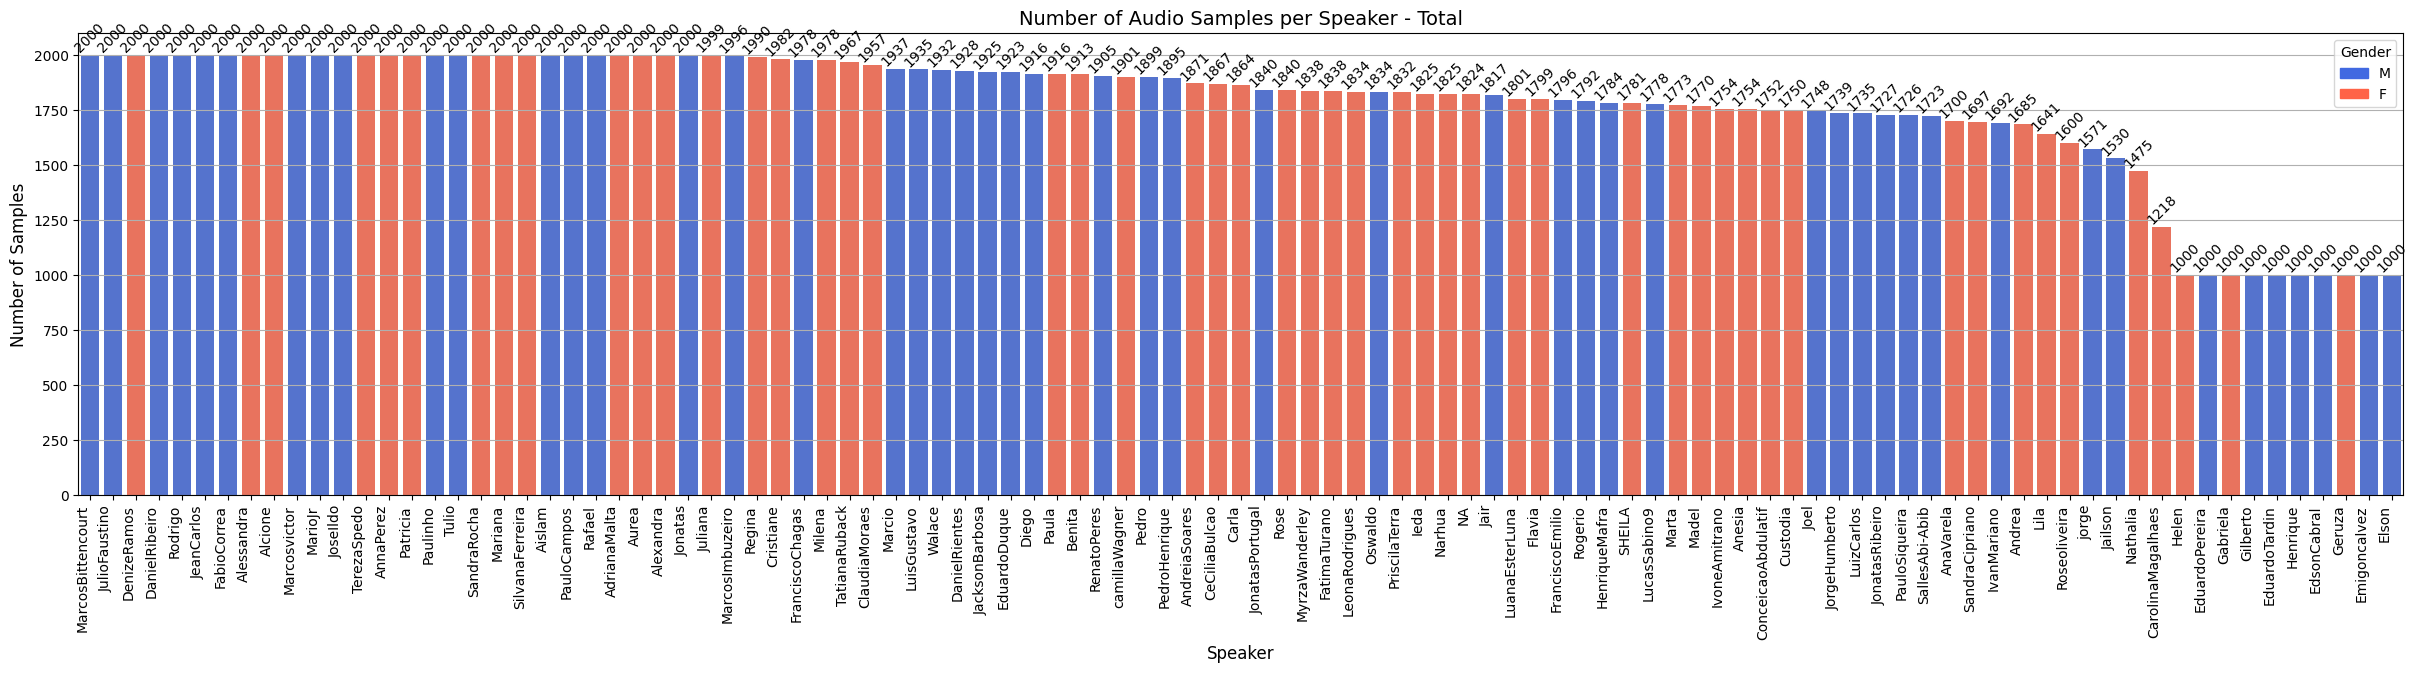

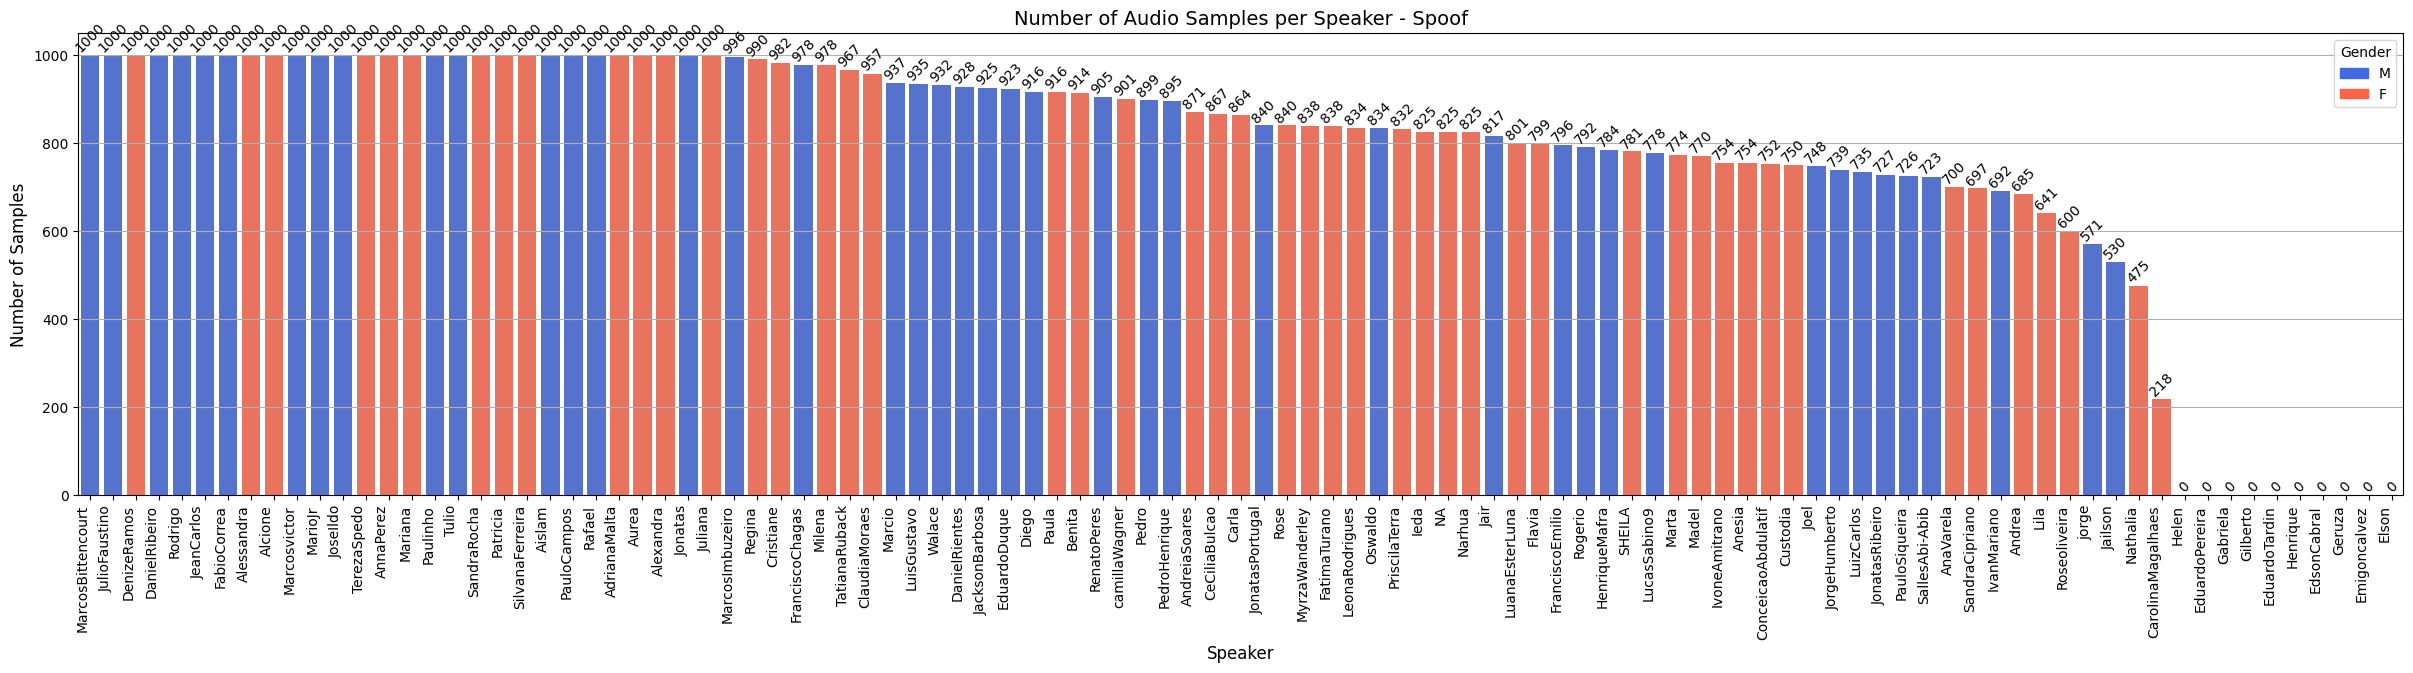

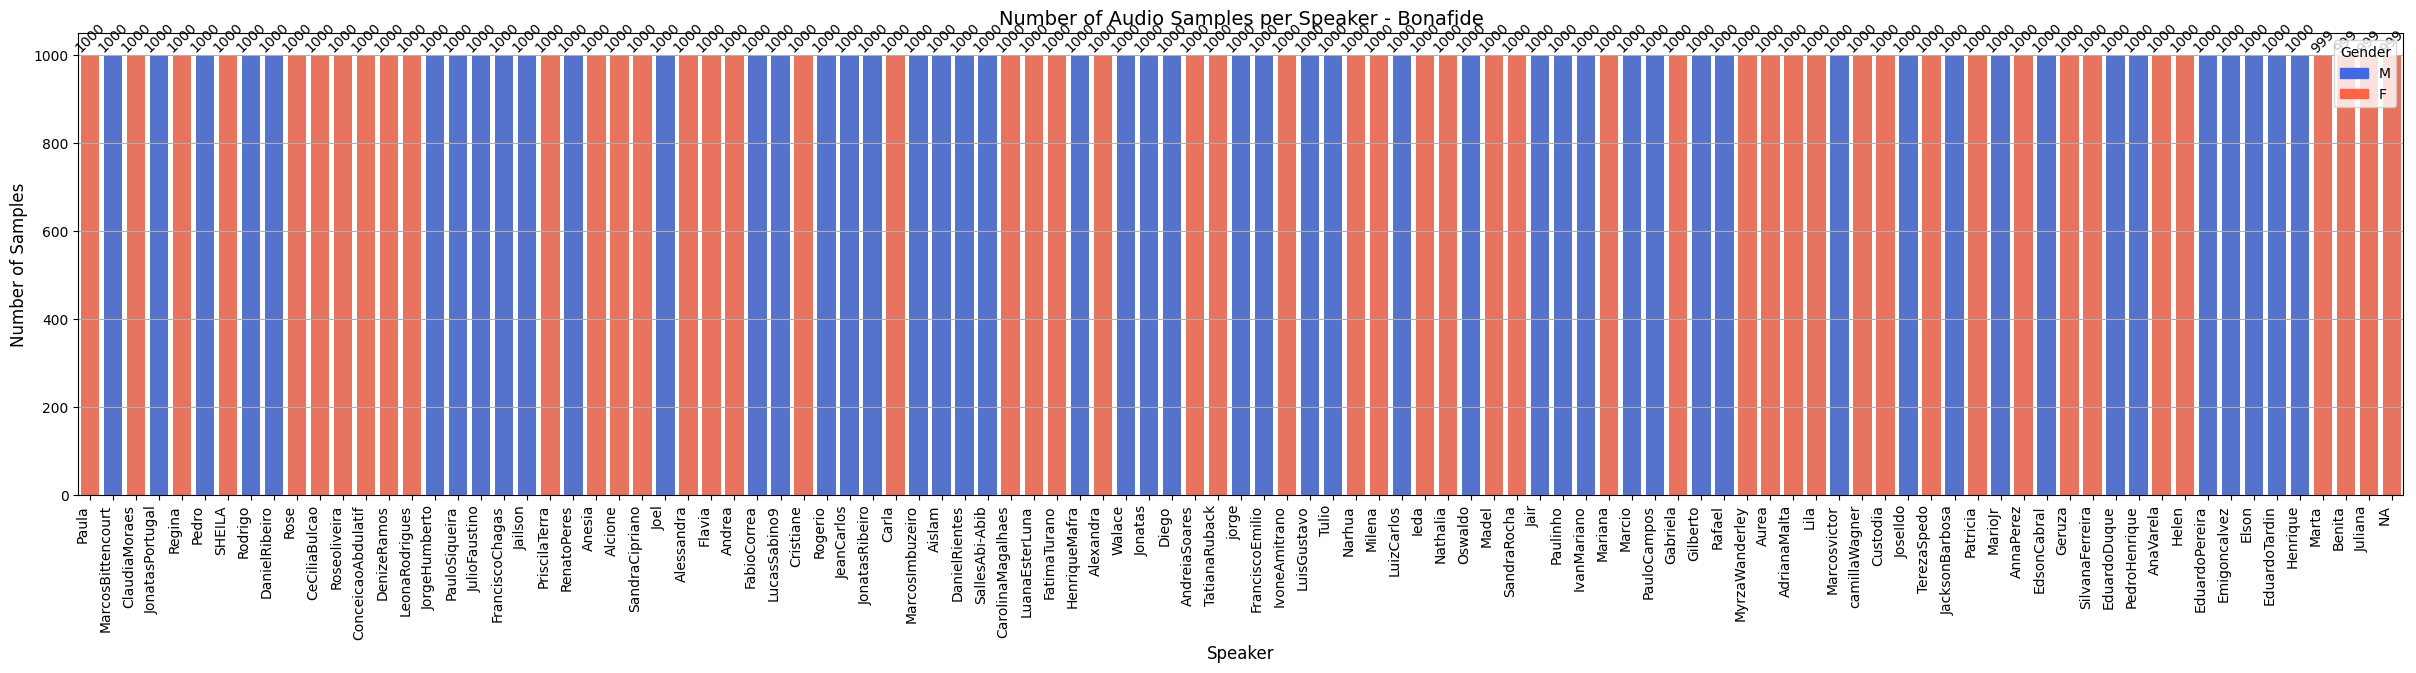

In [16]:
plot_bar_chart(dataset_people_df.sort_values(by='total_count', ascending=False), 'person', 'total_count', 'gender', "Number of Audio Samples per Speaker - Total")
plot_bar_chart(dataset_people_df.sort_values(by='spoof_count', ascending=False), 'person', 'spoof_count', 'gender', "Number of Audio Samples per Speaker - Spoof")
plot_bar_chart(dataset_people_df.sort_values(by='bonafide_count', ascending=False), 'person', 'bonafide_count', 'gender', "Number of Audio Samples per Speaker - Bonafide")

#### Part 3.3: Audio Amplitude Analysis <a class="anchor" id="part_03_03"></a>

In [17]:
print("amplitude mean of each class")
dataset_metadata_df.groupby("label")['amplitude'].mean()

amplitude mean of each class


label
bona-fide    0.322483
spoof        0.850445
Name: amplitude, dtype: float64

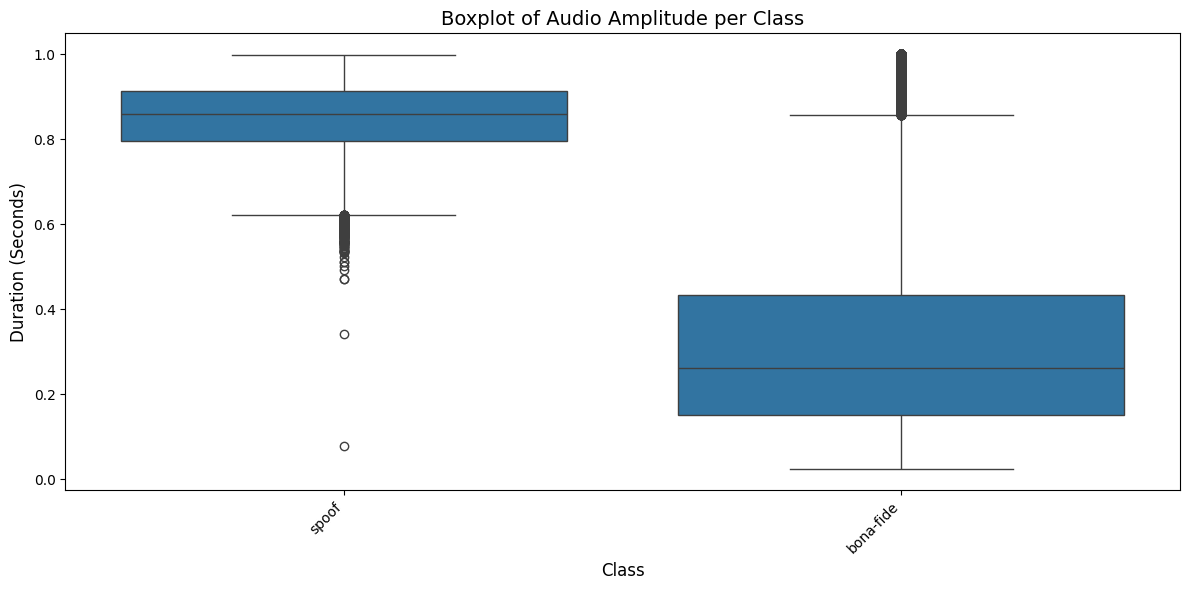

In [ ]:
# Create the boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(data=dataset_metadata_df, x='label', y='amplitude')

# Customize the plot
plt.title("Boxplot of Audio Amplitude per Class", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Duration (Seconds)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
print("amplitude mean of each gender")
dataset_metadata_df.groupby("gender")['amplitude'].mean()

amplitude mean of each gender


gender
F    0.557066
M    0.550601
Name: amplitude, dtype: float64

In [20]:
print("amplitude mean of each class, divided by gender")
dataset_metadata_df.groupby(["label", "gender"])['amplitude'].mean()

amplitude mean of each class, divided by gender


label      gender
bona-fide  F         0.341894
           M         0.302686
spoof      F         0.825911
           M         0.876797
Name: amplitude, dtype: float64

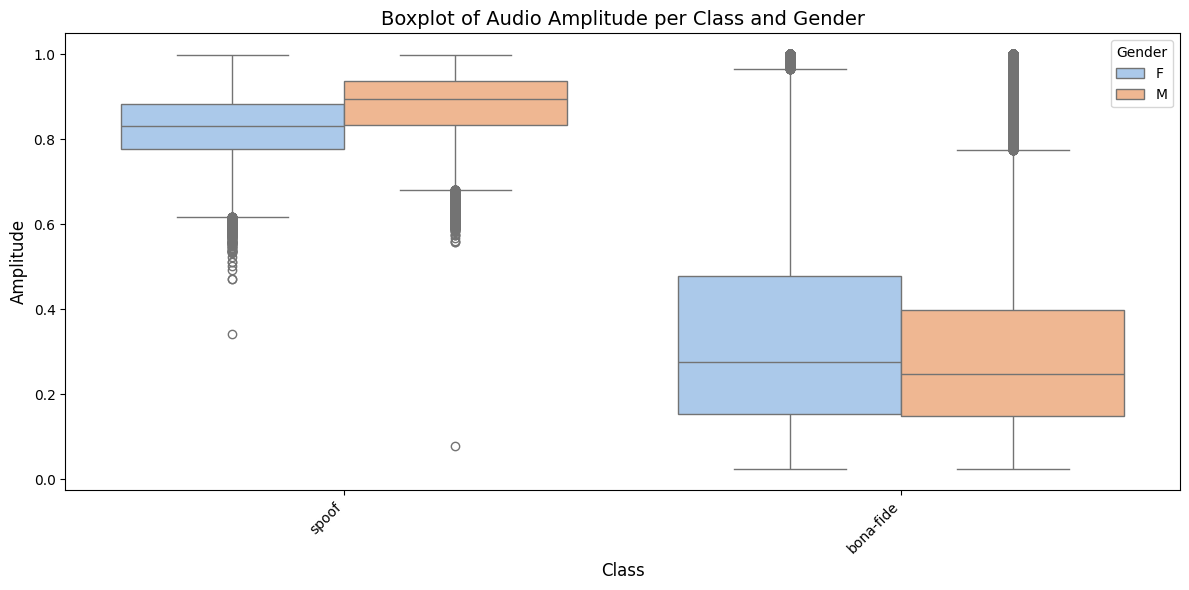

In [ ]:
# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=dataset_metadata_df, x='label', y='amplitude', hue='gender', palette={'M': 'royalblue', 'F': 'tomato'})

# Customize the plot
plt.title("Boxplot of Audio Amplitude per Class and Gender", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.legend(title="Gender")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

#### Part 3.4: Dataset Balance Analysis <a class="anchor" id="part_03_04"></a>

##### Part 3.4.1: Balance by Class

In [22]:
print("samples by class")
dataset_metadata_df['label'].value_counts()

samples by class


label
bona-fide    100996
spoof         78816
Name: count, dtype: int64

In [ ]:
print("hours by class")
dataset_metadata_df.groupby("label")['duration'].sum().sort_values(ascending=False) / 3600

minutes by class


label
bona-fide    8679.274211
spoof        6054.537244
Name: duration, dtype: float64

In [24]:
print("duration mean of each class")
dataset_metadata_df.groupby("label")['duration'].mean()

duration mean of each class


label
bona-fide    5.156209
spoof        4.609118
Name: duration, dtype: float64

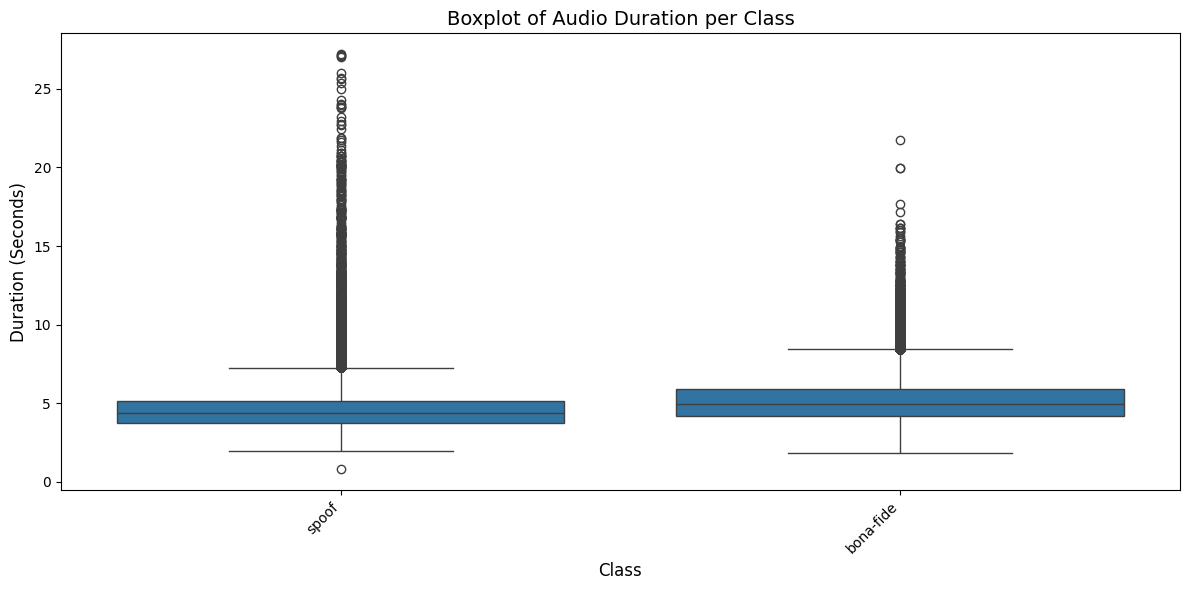

In [ ]:
# Create the boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(data=dataset_metadata_df, x='label', y='duration')

# Customize the plot
plt.title("Boxplot of Audio Duration per Class", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Duration (Seconds)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

##### Part 3.4.2: Balance by Gender

In [26]:
print("samples by gender")
dataset_metadata_df['gender'].value_counts()

samples by gender


gender
F    91811
M    88001
Name: count, dtype: int64

In [27]:
print("minutes by gender")
dataset_metadata_df.groupby("gender")['duration'].sum().sort_values(ascending=False) / 60

minutes by gender


gender
F    7597.189055
M    7136.622401
Name: duration, dtype: float64

In [28]:
print("duration mean of each gender")
dataset_metadata_df.groupby("gender")['duration'].mean()

duration mean of each gender


gender
F    4.964888
M    4.865824
Name: duration, dtype: float64

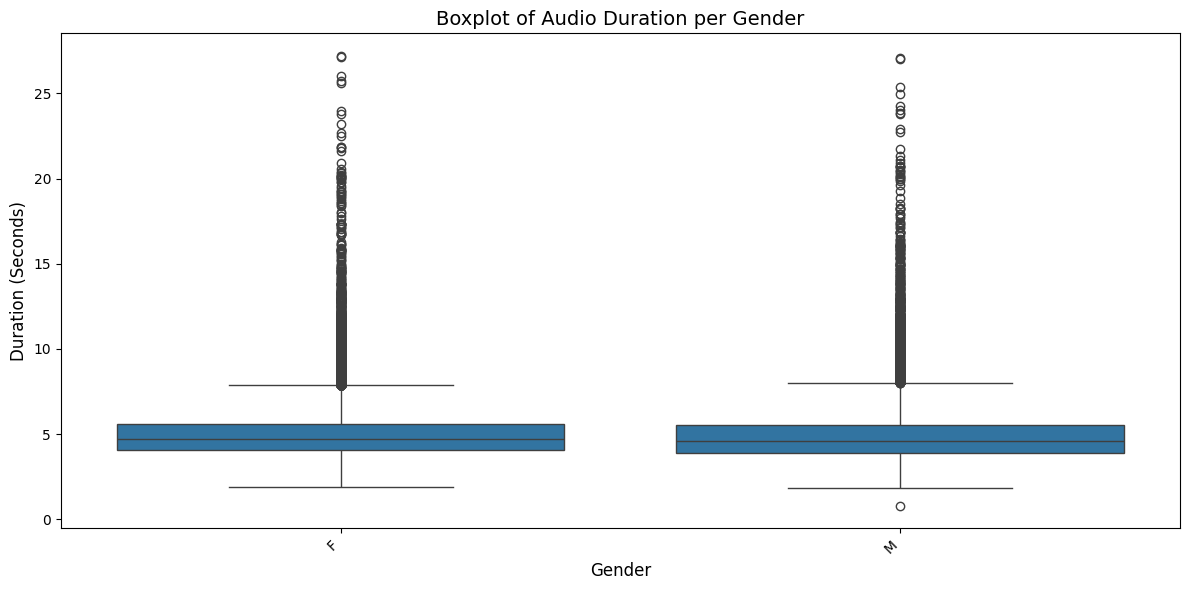

In [29]:
# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=dataset_metadata_df, x='gender', y='duration')

# Customize the plot
plt.title("Boxplot of Audio Duration per Gender", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Duration (Seconds)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

##### Part 3.4.3: Balance by Class and Gender

In [30]:
print("samples by class and gender")
dataset_metadata_df.groupby(['label', 'gender']).size()

samples by class and gender


label      gender
bona-fide  F         50996
           M         50000
spoof      F         40815
           M         38001
dtype: int64

In [ ]:
print("hours by class and gender")
dataset_metadata_df.groupby(["label", "gender"])['duration'].sum().sort_values(ascending=False) / 3600

minutes by class and gender


label      gender
bona-fide  F         4372.021766
           M         4307.252446
spoof      F         3225.167289
           M         2829.369956
Name: duration, dtype: float64

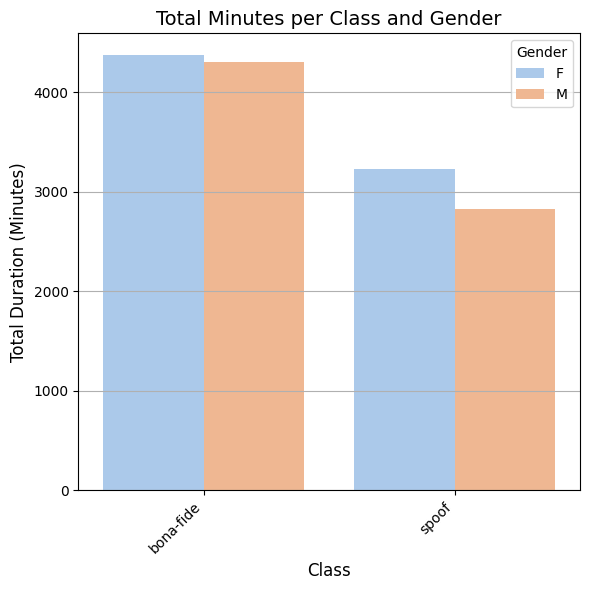

In [ ]:
# Aggregate the data: Total duration grouped by class and gender, converted to minutes
grouped_data = dataset_metadata_df.groupby(['label', 'gender'])['duration'].sum().reset_index()
grouped_data['duration_minutes'] = grouped_data['duration'] / 60  # Convert to minutes

# Create the bar plot using Seaborn
plt.figure(figsize=(6, 6))
sns.barplot(
    data=grouped_data,
    x='label',  # Group by class
    y='duration_minutes',  # Total duration in minutes
    hue='gender',  # Separate bars by gender
    palette={'M': 'royalblue', 'F': 'tomato'}
)

# Customize the plot
plt.title("Total Minutes per Class and Gender", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Total Duration (Minutes)", fontsize=12)
plt.legend(title="Gender")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()

# Show the plot
plt.show()

In [33]:
print("duration mean of each class and gender")
dataset_metadata_df.groupby(["label", "gender"])['duration'].mean()

duration mean of each class and gender


label      gender
bona-fide  F         5.143958
           M         5.168703
spoof      F         4.741150
           M         4.467309
Name: duration, dtype: float64

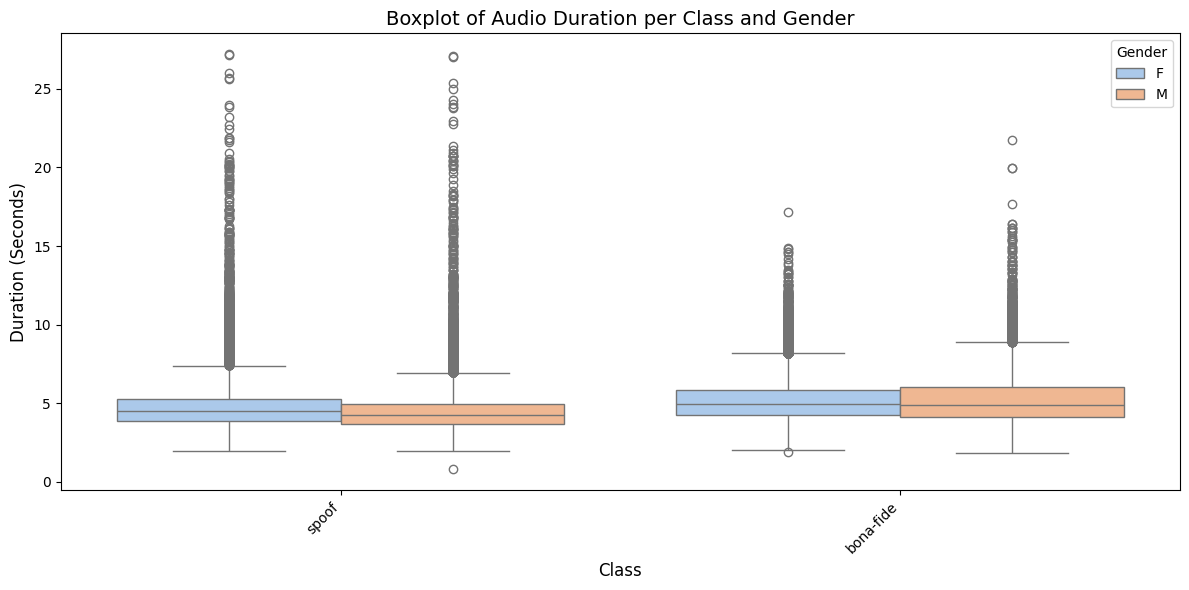

In [ ]:
# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=dataset_metadata_df, x='label', y='duration', hue='gender', palette={'M': 'royalblue', 'F': 'tomato'})

# Customize the plot
plt.title("Boxplot of Audio Duration per Class and Gender", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Duration (Seconds)", fontsize=12)
plt.legend(title="Gender")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

[Back to top](#topo)